# Strojenie modelu BERT-base na danych *cyberbullying*

## Biblioteki

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, AutoTokenizer
import torch
from transformers import BertForSequenceClassification, BertForTokenClassification, Trainer, TrainingArguments,  DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import kagglehub
from datasets import Dataset, DatasetDict
import json
from excel2json import convert_from_file
import seaborn as sns

## Załadowanie danych

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Teksty

In [3]:
# path = kagglehub.dataset_download("waalbannyantudre/hate-speech-detection-curated-dataset")

# print("Path to dataset files:", path)

In [4]:
df = pd.read_csv('HateSpeechDataset.csv')
df['text'] = df['Content']
df = df.drop(columns=['Content_int', 'Content'])
df = df[df['Label'] != 'Label']
display(df.head())

,Label,text
0,1,denial of normal the con be asked to comment o...
1,1,just by being able to tweet this insufferable ...
2,1,that is retarded you too cute to be single tha...
3,1,thought of a real badass mongol style declarat...
4,1,afro american basho


In [5]:
texts_train, texts_test, text_labels_train, text_labels_test = train_test_split(
    df['text'], df['Label'], test_size=0.2, random_state=42
)

In [6]:
df_train = pd.DataFrame()
df_train['text'] = texts_train
df_train['LABEL'] = text_labels_train

df_test = pd.DataFrame()
df_test['text'] = texts_test
df_test['LABEL'] = text_labels_test

In [7]:
# min_class_count = df_train['LABEL'].value_counts().min()
min_class_count_train = 1000
min_class_count_test = 500

df_train_balanced = df_train.groupby('LABEL').apply(lambda x: x.sample(min_class_count_train)).reset_index(drop=True)
df_test_balanced = df_test.groupby('LABEL').apply(lambda x: x.sample(min_class_count_test)).reset_index(drop=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_7548\4132669510.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_balanced = df_train.groupby('LABEL').apply(lambda x: x.sample(min_class_count_train)).reset_index(drop=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_7548\4132669510.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_balanced = df_test.groupby('LABEL').apply(lambda x: x.sample(m

In [8]:
train_json = df_train_balanced.to_json(orient='records')
test_json = df_test_balanced.to_json(orient='records')


train_dataset = Dataset.from_list(json.loads(train_json))
test_dataset = Dataset.from_list(json.loads(test_json))


dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [9]:
print(dataset['train'])

Dataset({
    features: ['text', 'LABEL'],
    num_rows: 2000
})


In [10]:
print(dataset['test'])

Dataset({
    features: ['text', 'LABEL'],
    num_rows: 1000
})


In [11]:
for entry in dataset['train'].select(range(5)):
    print('TEXT: {} \nLABEL: {}\n'.format(entry['text'], entry['LABEL']))

TEXT: hey do you think whatever are going to get into a fight between european countries about whom all are going to get those guantanamo prisoners 
LABEL: 0

TEXT: did not i give you my myspace 
LABEL: 0

TEXT: wine chill thank god shit week 
LABEL: 0

TEXT: main page i think whoever is really writing this article should try to get it featured on the main page before the election because after the election who cares 
LABEL: 0

TEXT: blocked per wikipediarequests for check user case europa and the related sock puppetry reports 
LABEL: 0



In [12]:
train_counts = pd.DataFrame({'Sentiment': dataset['train']['LABEL']})
train_counts = train_counts.groupby('Sentiment').size().reset_index(name='train_set')

test_counts = pd.DataFrame({'Sentiment': dataset['test']['LABEL']})
test_counts = test_counts.groupby('Sentiment').size().reset_index(name='test_set')

display(train_counts.merge(test_counts, on='Sentiment'))

,Sentiment,train_set,test_set
0,0,1000,500
1,1,1000,500


## Strojenie modelu dla zadania klasyfikacji tekstu

In [28]:
sorted_labels = sorted(set(dataset['train']['LABEL']))
label2id = dict(zip(sorted_labels, range(0, len(sorted_labels))))
id2label = dict(zip(range(0, len(sorted_labels)), sorted_labels))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                    num_labels=len(label2id),
                                                                    label2id=label2id,
                                                                    id2label=id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def preprocess_function(examples):
    """Preprocess the dataset by returning tokenized examples."""
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True)
    tokens['label'] = [label2id[l] for l in examples["LABEL"]]
    return tokens

splits = ['train', 'test']

tokenized_ds = {} 

for split in splits:
    tokenized_ds[split] = dataset[split].map(preprocess_function, batched=True)

print(tokenized_ds)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['text', 'LABEL', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 2000
}), 'test': Dataset({
    features: ['text', 'LABEL', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
})}


In [15]:
print("A tokenized training input example:")
print(tokenized_ds["train"][0]["input_ids"])
print("\n")
print("A tokenized training label example:")
print(tokenized_ds["train"][0]["label"])
print(tokenized_ds["train"][0]['attention_mask'])

A tokenized training input example:
[101, 4931, 2079, 2017, 2228, 3649, 2024, 2183, 2000, 2131, 2046, 1037, 2954, 2090, 2647, 3032, 2055, 3183, 2035, 2024, 2183, 2000, 2131, 2216, 23094, 5895, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()*100, "f1": f1_score(labels, predictions, labels=[0, 1], pos_label=1)}



# trainer = Trainer(
#     model=model,
#     args=TrainingArguments(
#         output_dir="bert-lora",
#         learning_rate=2e-3,
#         # Reduce the batch size if you don't have enough memory
#         per_device_train_batch_size=2,
#         per_device_eval_batch_size=2,
#         num_train_epochs=1,
#         weight_decay=0.01,
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         load_best_model_at_end=True,
#     ),
#     train_dataset=tokenized_ds["train"],
#     eval_dataset=tokenized_ds["test"],
#     tokenizer=tokenizer,
#     data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
#     compute_metrics=compute_metrics,
# )

# print("Starting to train...")
# trainer.train()

In [17]:
# noun_model_path = 'sentence_model-weights/'
# model.save_pretrained(noun_model_path)

#### PEFT-BERT

In [72]:
from peft import LoraConfig, get_peft_model, TaskType

# lora_config = LoraConfig(
#     task_type=TaskType.SEQ_CLS,
#     r=8,  # Mniejsza liczba parametrów do trenowania
#     lora_alpha=16,
#     lora_dropout=0.1
# )

# lora_config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     target_modules=["query", "value"],
#     lora_dropout=0.05,
#     bias="none",
#     task_type=TaskType.SEQ_CLS, # this is necessary
#     inference_mode=True)


lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=8, lora_alpha=1, lora_dropout=0.1
)
# 1, 1, 1

model_2 = get_peft_model(model, lora_config)

In [73]:
trainer_2 = Trainer(
    model=model_2,
    args=TrainingArguments(
        output_dir="bert-lora",
        learning_rate=2e-3,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=5,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

print("Starting to train...")
trainer_2.train()

d:\Python\Lib\site-packages\transformers\training_args.py:1559: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

C:\Users\DELL\AppData\Local\Temp\ipykernel_7548\4108694946.py:1: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Starting to train...


  0%|          | 0/5000 [00:00<?, ?it/s]

{'loss': 0.8705, 'grad_norm': 0.1618676483631134, 'learning_rate': 0.0018000000000000002, 'epoch': 0.5}
{'loss': 0.7256, 'grad_norm': 0.03846873715519905, 'learning_rate': 0.0016, 'epoch': 1.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.6621653437614441, 'eval_accuracy': 81.39999999999999, 'eval_f1': 0.8312159709618875, 'eval_runtime': 37.9605, 'eval_samples_per_second': 26.343, 'eval_steps_per_second': 13.172, 'epoch': 1.0}
{'loss': 0.6164, 'grad_norm': 6.090638637542725, 'learning_rate': 0.0014, 'epoch': 1.5}
{'loss': 0.5649, 'grad_norm': 0.5000209212303162, 'learning_rate': 0.0012, 'epoch': 2.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.5224799513816833, 'eval_accuracy': 82.39999999999999, 'eval_f1': 0.8367346938775511, 'eval_runtime': 38.008, 'eval_samples_per_second': 26.31, 'eval_steps_per_second': 13.155, 'epoch': 2.0}
{'loss': 0.4572, 'grad_norm': 0.2570779621601105, 'learning_rate': 0.001, 'epoch': 2.5}
{'loss': 0.4538, 'grad_norm': 5.348005294799805, 'learning_rate': 0.0008, 'epoch': 3.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.6984723806381226, 'eval_accuracy': 82.69999999999999, 'eval_f1': 0.8278606965174129, 'eval_runtime': 37.9788, 'eval_samples_per_second': 26.33, 'eval_steps_per_second': 13.165, 'epoch': 3.0}
{'loss': 0.3696, 'grad_norm': 0.010761415585875511, 'learning_rate': 0.0006, 'epoch': 3.5}
{'loss': 0.349, 'grad_norm': 0.2305784523487091, 'learning_rate': 0.0004, 'epoch': 4.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.7941100001335144, 'eval_accuracy': 82.89999999999999, 'eval_f1': 0.8235294117647058, 'eval_runtime': 37.9408, 'eval_samples_per_second': 26.357, 'eval_steps_per_second': 13.178, 'epoch': 4.0}
{'loss': 0.3311, 'grad_norm': 0.20046789944171906, 'learning_rate': 0.0002, 'epoch': 4.5}
{'loss': 0.2331, 'grad_norm': 0.008772463537752628, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.7348750233650208, 'eval_accuracy': 84.39999999999999, 'eval_f1': 0.8514285714285714, 'eval_runtime': 38.0418, 'eval_samples_per_second': 26.287, 'eval_steps_per_second': 13.143, 'epoch': 5.0}
{'train_runtime': 1100.3622, 'train_samples_per_second': 9.088, 'train_steps_per_second': 4.544, 'train_loss': 0.49712134399414065, 'epoch': 5.0}


TrainOutput(global_step=5000, training_loss=0.49712134399414065, metrics={'train_runtime': 1100.3622, 'train_samples_per_second': 9.088, 'train_steps_per_second': 4.544, 'total_flos': 2640217497600000.0, 'train_loss': 0.49712134399414065, 'epoch': 5.0})

In [ ]:
model_path = 'pert_model-weights/'
model_2.save_pretrained(model_path)

## Ocena jakości predyckji

### Teksty

In [74]:
predictions = trainer_2.predict(tokenized_ds['test'])

predicted_labels = predictions.predictions.argmax(axis=1)  
true_labels = predictions.label_ids 
metrics = predictions.metrics

print("Wyniki:")
print("-" * 20)
for key, value in metrics.items():
    print(f"{key.replace('_', ' ').title()}: {value:.4f}" if isinstance(value, float) else f"{key.replace('_', ' ').title()}: {value}")

  0%|          | 0/500 [00:00<?, ?it/s]

Wyniki:
--------------------
Test Loss: 0.5225
Test Accuracy: 82.4000
Test F1: 0.8367
Test Runtime: 54.7493
Test Samples Per Second: 18.2650
Test Steps Per Second: 9.1330


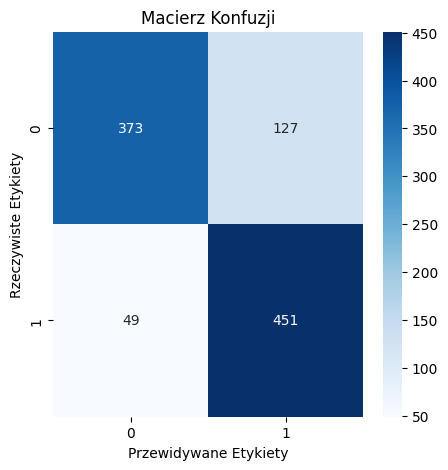

In [75]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

labels = np.unique(true_labels)  
confusion_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.title('Macierz Konfuzji')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Rzeczywiste Etykiety')
plt.show()

## Wizualizacja przestrzeni wektorowej

### Teksty

In [76]:
def embed_text(examples):
    tokens = tokenizer(examples, padding="max_length", truncation=True)
    return tokens

def wrap_text(text, width=40):
    return '<br>'.join([text[i:i+width] for i in range(0, len(text), width)])


In [77]:
text = pd.DataFrame(tokenized_ds['test']['text'], columns=['text'])
text['text'] = text['text'].apply(wrap_text)

embeddings = embed_text(dataset['test']['text'])

#### PCA

In [78]:
pca = PCA(n_components=2).fit_transform(embeddings['input_ids'])

df_pca = pd.DataFrame(pca, columns=['PCA1', 'PCA2'])
df_pca['Predicted Label']  = [predicted_labels[i] for i in range(len(predicted_labels))]
df_pca['Text'] = text['text']
df_pca['True label'] = [true_labels[i] for i in range(len(true_labels))]

fig = px.scatter(df_pca, x="PCA1", y="PCA2", color="Predicted Label", hover_data={'Text': True, 'True label': True}, title="Wizualizacja przestrzeni wektorowej prób testowych",
                labels={"PC1": "Pierwsza składowa główna", "PC2": "Druga składowa główna"})
fig.show()

#### TSNE

In [79]:
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(embeddings['input_ids'])

tsne = TSNE(n_components=2, random_state=42).fit_transform(scaled_vectors)

df_tsne = pd.DataFrame(tsne, columns=['x', 'y'])
df_tsne['Predicted Label']  = [predicted_labels[i] for i in range(len(predicted_labels))]
df_tsne['Text'] = text['text']
df_tsne['True label'] = [true_labels[i] for i in range(len(true_labels))]

fig = px.scatter(df_tsne, x='x', y='y', color='Predicted Label', hover_data={'Text': True, 'True label': True}, title="Wizualizacja przestrzeni wektorowej prób testowych")
fig.show()